## Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

Plan:
* Study how to use OpenAI gym
* Basic prototype of evolutionary strategies that works in one thread on CartPole
* Modify the code to make them work in parallel
* Use the algorithm to solve the LunarLander
* Analyse the influence of hyperparameters

( Nghiên cứu cách sử dụng OpenAI gym

Nguyên mẫu cơ bản của chiến lược tiến hóa hoạt động trên một luồng với CartPole

Sửa đổi mã để làm cho chúng hoạt động song song

Sử dụng thuật toán để giải quyết LunarLander

Phân tích ảnh hưởng của các siêu tham số )

In [96]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [97]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display

# Dòng này chỉ dùng trong môi trường Jupyter Notebook:
%matplotlib inline


# OpenAI gym environment

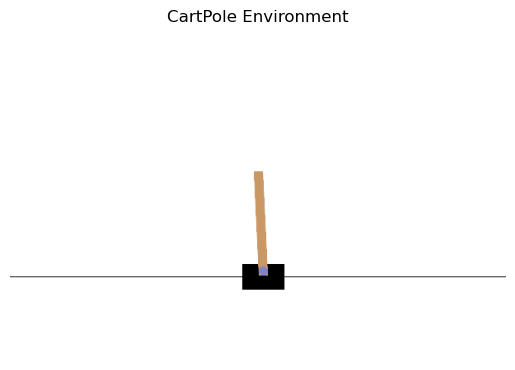

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
State size: 4
Number of actions: 2


In [98]:
import gym
import matplotlib.pyplot as plt

# Tạo môi trường CartPole-v0 với chế độ render là 'rgb_array'
tmp_env = gym.make("CartPole-v0", render_mode='rgb_array')

# Đặt lại trạng thái ban đầu của môi trường (trả về observation, info)
observation, info = tmp_env.reset()

# Lấy hình ảnh từ môi trường (dưới dạng mảng RGB)
img = tmp_env.render()

# Hiển thị hình ảnh của môi trường bằng matplotlib
plt.imshow(img)
plt.title("CartPole Environment")
plt.axis('off')  # Ẩn trục để hình ảnh đẹp hơn
plt.show()

# In ra không gian quan sát (observation space)
print("Observation space:", tmp_env.observation_space)

# In ra không gian hành động (action space)
print("Action space:", tmp_env.action_space)

# Lấy kích thước của không gian quan sát (số lượng đặc trưng trong trạng thái)
state_size = tmp_env.observation_space.shape[0]

# Lấy số lượng hành động có thể thực hiện trong môi trường
n_actions = tmp_env.action_space.n

print("State size:", state_size)
print("Number of actions:", n_actions)


### How to interact with the environment

In [128]:
import gym

# Tạo môi trường CartPole-v0
tmp_env = gym.make("CartPole-v0", render_mode='rgb_array')

# Reset môi trường và nhận trạng thái ban đầu + thông tin phụ
observation, info = tmp_env.reset()
print("Initial observation:", observation)  # In ra trạng thái ban đầu

# Thực hiện hành động 0 (giữ cột thẳng đứng)
new_observation, reward, terminated, truncated, info = tmp_env.step(0)

# Tính xem trò chơi có kết thúc không (do thắng/thua hoặc quá số bước)
done = terminated or truncated

# In ra thông tin từng bước
print("At each step it returns:")
print("new observation:", new_observation)
print("reward:", reward)
print("is game over?:", done)


Initial observation: [ 0.02661874  0.02388939  0.00205288 -0.0462423 ]
At each step it returns:
new observation: [ 0.02709653 -0.17126194  0.00112804  0.24708763]
reward: 1.0
is game over?: False


### Display an episode

In [134]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = env.reset()
    if isinstance(s, tuple):  # Nếu trạng thái trả về là tuple (state, info)
        s = s[0]
    s = np.array(s)  # Chuyển đổi trạng thái thành mảng NumPy nếu cần

    for t in range(t_max):
        plt.gca().clear()

        a = agent.get_action(torch.tensor(s).float())
        new_s, r, terminated, truncated, info = env.step(a)
        s = new_s
        total_reward += r

        # Kiểm tra dữ liệu từ env.render()
        frame = env.render()
        if isinstance(frame, np.ndarray):
            plt.imshow(frame)
        else:
            print("Render returned invalid data:", type(frame))
            break

        display.display(plt.gcf())
        display.clear_output(wait=True)

        if truncated or terminated:
            break
            
    return total_reward

### Random policy

In [135]:
class RandomPolicy:
    def __init__(self, n_actions):
        """
        Khởi tạo chính sách ngẫu nhiên với số lượng hành động.
        :param n_actions: Số lượng hành động có thể thực hiện.
        """
        self.n_actions = n_actions

    def get_action(self, state):
        """
        Trả về một hành động ngẫu nhiên.
        :param state: Trạng thái hiện tại của môi trường (không sử dụng trong chính sách ngẫu nhiên).
        :return: Một hành động ngẫu nhiên.
        """
        return np.random.choice(self.n_actions)
    #pass

In [136]:
total_reward = display_session(tmp_env, RandomPolicy(n_actions))
print('Total reward: ', total_reward)

Total reward:  22.0


# The challenge of the day

![Algorithm](https://i.ibb.co/zFm6BrB/Screenshot-from-2021-09-17-13-38-00.png)

### Model evaluation

(Đánh giá mô hình)

In [148]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0]
    s = np.array(s)  # Đảm bảo s là mảng NumPy
    for t in range(t_max):
         # Chuyển đổi state thành tensor
        state_tensor = torch.tensor(s, dtype=torch.float32)
        a = agent.get_action(state_tensor)
        
        # Thực hiện bước trong môi trường
        new_s, r, terminated, truncated, info = env.step(a)
        total_reward += r
        
        # Xử lý new_s nếu cần
        if isinstance(new_s, tuple):
            new_s = new_s[0]
        s = np.array(new_s)
        if terminated or truncated:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    pass

### Modification of the model using a noise 

In [149]:
def add_noise_to_model(model, noise, copy=False):
    """
    Thêm nhiễu vào các tham số của mô hình.
    
    :param model: Mô hình PyTorch (torch.nn.Module).
    :param noise: Nhiễu (dạng tensor hoặc mảng NumPy) có cùng kích thước với các tham số của mô hình.
    :param copy: Nếu True, trả về một bản sao của mô hình với nhiễu được thêm vào.
                 Nếu False, thay đổi trực tiếp mô hình ban đầu.
    :return: Mô hình với nhiễu được thêm vào (nếu copy=True).
    """
    if copy:
        # Tạo một bản sao của mô hình
        model = deepcopy(model)
    
    # Thêm nhiễu vào các tham số của mô hình
    with torch.no_grad():
        for param, noise_param in zip(model.parameters(), noise):
            param.add_(noise_param)
    
    if copy:
        return model
    #pass

### Controller of the evolution

#### Task 1: Implement the algorithm

In [150]:
class EvolutionManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, n_samples = 64, normalize=True):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        
        self.env = get_env_function()
        
    def get_noised_model(self, model):
        """
        Tạo các bản sao của mô hình với nhiễu Gaussian.
        :param model: Mô hình PyTorch ban đầu.
        :return: Danh sách các mô hình với nhiễu được thêm vào.
        """
        noises = [torch.randn_like(param) * self.std for param in model.parameters()]
        noised_model = add_noise_to_model(model, noises, copy=True)
        return noised_model, noises
        #pass

    def optimize(self, model, noises, rewards):
        """
        Tối ưu hóa mô hình dựa trên phần thưởng và nhiễu.
        :param model: Mô hình PyTorch ban đầu.
        :param noises: Danh sách nhiễu đã thêm vào mô hình.
        :param rewards: Danh sách phần thưởng tương ứng với các mô hình nhiễu.
        """
        if self.normalize:
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)
        
        with torch.no_grad():
            for param, noise in zip(model.parameters(), zip(*noises)):
                gradient = np.mean([r * n for r, n in zip(rewards, noise)], axis=0)
                param.add_(self.lr * torch.tensor(gradient, dtype=param.dtype))
        #pass
    
    def step(self, model):
        """
        Thực hiện một bước của chiến lược tiến hóa.
        :param model: Mô hình PyTorch ban đầu.
        """
        noises = []
        rewards = []
        
        # Tạo các mô hình nhiễu và tính phần thưởng
        for _ in range(self.n_samples):
            noised_model, noise = self.get_noised_model(model)
            reward = generate_session(self.env, noised_model)
            noises.append(noise)
            rewards.append(reward)
        
        # Tối ưu hóa mô hình
        self.optimize(model, noises, rewards)
        
        # Cập nhật log
        self.update_log(rewards)
        #pass
        
    def update_log(self, rewards):
        """
        Cập nhật log phần thưởng.
        :param rewards: Danh sách phần thưởng.
        """
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()
    

#### Task 2: Implement a neural network-based policy

(Thực hiện chính sách dựa trên mạng nơ ron)

### Neural policy

(chính sách nơ ron)

In [157]:
class MLPPolicy(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        """
        Khởi tạo mạng nơ-ron chính sách.
        :param input_dim: Số chiều của đầu vào (state size).
        :param output_dim: Số chiều của đầu ra (action size).
        :param hidden_dim: Số lượng neuron trong lớp ẩn.
        """
        super(MLPPolicy, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        """
        Tính toán đầu ra của mạng nơ-ron.
        :param x: Đầu vào (state).
        :return: Đầu ra (logits hoặc xác suất hành động).
        """
        return self.model(x)
    
    def get_action(self, state):
        """
        Lấy hành động dựa trên trạng thái đầu vào.
        :param state: Trạng thái hiện tại (tensor).
        :return: Hành động được chọn (int).
        """
        logits = self.forward(state)
        action_probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(action_probs, num_samples=1).item()
        return action
    #pass

### Environment 1: CartPole-v0

In [152]:
def get_env_function():
    env = gym.make('CartPole-v0').env
    return env
tmp_env = get_env_function()

c:\Anaconda\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [160]:
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n
model = MLPPolicy(n_states, n_actions)
#model = model.float()
print("Model initialized:")
print(model)

Model initialized:
MLPPolicy(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


last mean reward = 22.938


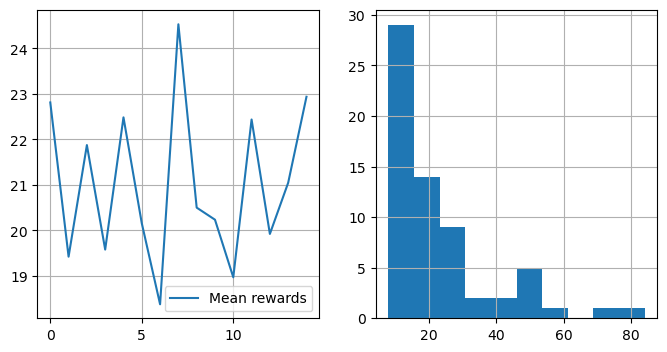

0.2866199016571045


In [161]:
algorithm = EvolutionManager(
    get_env_function=get_env_function,  # Hàm tạo môi trường
    lr=0.01,                           # Tốc độ học
    std=0.1,                           # Độ lệch chuẩn của nhiễu
    n_samples=64,                      # Số lượng mẫu nhiễu
    normalize=True                     # Chuẩn hóa phần thưởng
)
np.bool8=np.bool_
for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

In [144]:
display_session(tmp_env, model, t_max=500)

Render returned invalid data: <class 'NoneType'>


c:\Anaconda\Lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


1.0

#### Task 3: Implement and compare the parallelized version of the algorithm

In [111]:
model = <>

SyntaxError: invalid syntax (257244038.py, line 1)

last mean reward = 353.210


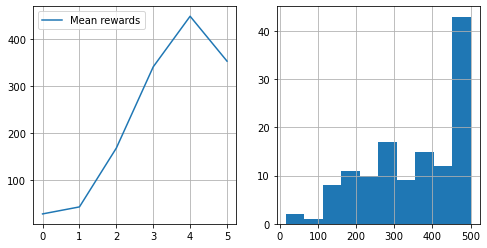

26.267060041427612


In [ ]:
algorithm = <>

for i in range(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

### Environment 2: LunarLanderContinuous-v2

In [ ]:
c:\Anaconda\python.exe -m pip install C:\Users\ADMIN\Downloads\Box2D-2.3.10-cp312-cp312-win_amd64.whl


Processing c:\downloads\box2d-2.3.10-cp312-cp312-win_amd64.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Downloads\\Box2D-2.3.10-cp312-cp312-win_amd64.whl'



In [165]:
def get_env_function():
    env = gym.make('LunarLanderContinuous-v2').env
    return env
tmp_env = get_env_function()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.shape[0]
model = MLPPolicy(n_states, n_actions)
algorithm = EvolutionManager(get_env_function, lr=0.01, std=0.1, n_samples=64, normalize=True)

for i in range(1000):
    algorithm.step(model)

IndexError: invalid index to scalar variable.

297.1928817226966

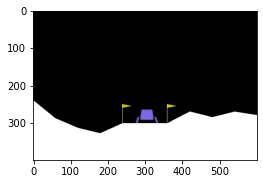

In [ ]:
display_session(tmp_env, model, t_max=500)

### Task 3: Hyperparameter's analysis

Now we are going to do some experimental analysis of the algorithm.

Plan:
- to learn something about the *std* parameter
- to learn something about the *learning rate* parameter
- to learn something about the *n_samples* parameter